In [75]:
import os
from tensorflow.keras.preprocessing.image import *
from PIL import Image


from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


In [2]:
train_file_path = os.path.expanduser('~/.keras/datasets/VOC2012/combined_imageset_train.txt')
val_file_path   = os.path.expanduser('~/.keras/datasets/VOC2012/combined_imageset_val.txt')
data_dir        = os.path.expanduser('~/.keras/datasets/VOC2012/VOCdevkit/VOC2012/JPEGImages')
label_dir       = os.path.expanduser('~/.keras/datasets/VOC2012/combined_annotations')
data_suffix='.jpg'
label_suffix='.png'
classes = 21

In [159]:



# class SimpleVOCGen():
    
#     def __init__(self, file_path):
#         self.file_path = file_path
        
#         # Load all file names.
#         with open(file_path) as fp:
#             self.files = [line.strip('\n') for line in fp.readlines()]
            
    
def inf_generator(file_path, do_random_transform=False):
    
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
    image_datagen = ImageDataGenerator(**data_gen_args)
    
    
    # Load all file names.
    with open(file_path) as fp:
        files2 = [line.strip('\n') for line in fp.readlines()]
    print("Generator with:", len(files2))

    while True:
        ix = int(np.random.uniform(0,len(files2)-1))
        print("fuck", ix, len(files2))

        line = files2[ix]
        #data_files.append(line + data_suffix)
        #label_files.append(line + label_suffix)

        x_fp = os.path.join(data_dir, line + data_suffix)
        y_fp = os.path.join(label_dir, line + label_suffix)

        # Load
        img = load_img(x_fp, grayscale=False, target_size=None)
        label = Image.open(y_fp)

        # To np    
        data_format = K.image_data_format()
        x = img_to_array(img, data_format=data_format)/255  # Rescale x to [0-1]
        y = img_to_array(label, data_format=data_format).astype(int)

        # TODO: Resize images

        if do_random_transform:
            tr = image_datagen.get_random_transform(label_ar.shape)

            x = image_datagen.apply_transform(x, tr)
            y = image_datagen.apply_transform(y, tr)

        # Add new one for 'batch', kinda.
        x = x[np.newaxis,:,:,:]
        y = y[np.newaxis,:,:,:]

        yield x, y


data_gen = inf_generator(train_file_path, do_random_transform=True)

In [160]:
a, b = next(data_gen)

Generator with: 10582
fuck 3046 10582


9313 11127
(334, 500, 3)


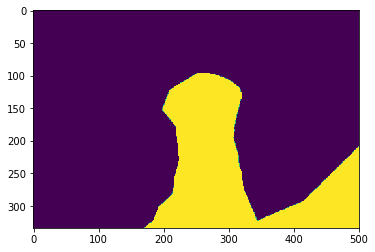

In [146]:
x, y = next(data_gen)

print(x[0].shape)

#plt.imshow(x[0,:,:,:])
plt.imshow(y[0,:,:,0])

In [176]:
from tensorflow.keras.callbacks import *

# ###############learning rate scheduler####################
def lr_scheduler(epoch): #, mode='power_decay'):
    '''if lr_dict.has_key(epoch):
        lr = lr_dict[epoch]
        print 'lr: %f' % lr'''
    
    mode = 'power_decay'
    lr = 0
    if mode is 'power_decay':
        # original lr scheduler
        lr = lr_base * ((1 - float(epoch)/epochs) ** lr_power)
    if mode is 'exp_decay':
        # exponential decay
        lr = (float(lr_base) ** float(lr_power)) ** float(epoch+1)
    # adam default lr
    if mode is 'adam':
        lr = 0.001

    if mode is 'progressive_drops':
        # drops as progression proceeds, good for sgd
        if epoch > 0.9 * epochs:
            lr = 0.0001
        elif epoch > 0.75 * epochs:
            lr = 0.001
        elif epoch > 0.5 * epochs:
            lr = 0.01
        else:
            lr = 0.1

    print('lr: %f' % lr)
    return lr
scheduler = LearningRateScheduler(lr_scheduler)

In [171]:

a, b = next(inp_gen)
print(a.shape, b.shape)

history = model.fit_generator(
    inf_generator(train_file_path, do_random_transform=True),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    workers=4,
    #validation_data=inf_generator(val_file_path),

    #validation_steps=64,
    # class_weight=class_weight
   )

W0326 01:38:34.997264 47951149037568 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


8564 11127
(1, 500, 269, 3) (1, 500, 269, 1)
Generator with: 10582
fuck 2447 10582
Train for 662 steps
0.009999999776482582


UnboundLocalError: local variable 'lr' referenced before assignment

In [177]:
# Actual training???
from models import *
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from utils.loss_function import *
from utils.metrics import *


loss_fn = softmax_sparse_crossentropy_ignoring_last_label  # Fancy expand label den do stuff.
batch_size = 16
batchnorm_momentum = 0.95
epochs = 250
lr_base = 0.01 * (float(batch_size) / 16)
lr_power = 0.9
resume_training = False
weight_decay = 0.0001/2
target_size = (320, 320)
metrics = [sparse_accuracy_ignoring_last_label]

save_path = os.path.join('./Models/AtrousFCN_Resnet50_16s')


# i.e. 3 channel img
input_shape = target_size + (3,)

model = AtrousFCN_Resnet50_16s(weight_decay=weight_decay,
                              input_shape=input_shape,
                              batch_momentum=batchnorm_momentum,
                              classes=classes)

# ###################### optimizer ########################
optimizer = SGD(lr=lr_base, momentum=0.9)
# optimizer = Nadam(lr=lr_base, beta_1 = 0.825, beta_2 = 0.99685)

# ------------------- compile -------------------
model.compile(loss=loss_fn,
              optimizer=optimizer,
              metrics=metrics)
#if resume_training:
#    model.load_weights(checkpoint_path, by_name=True)
model_path = os.path.join(save_path, "model.json")
# save model structure
f = open(model_path, 'w')
model_json = model.to_json()
f.write(model_json)
f.close
img_path = os.path.join(save_path, "model.png")
# #vis_util.plot(model, to_file=img_path, show_shapes=True)
model.summary()

# lr_reducer      = ReduceLROnPlateau(monitor=softmax_sparse_crossentropy_ignoring_last_label, factor=np.sqrt(0.1),
#                                     cooldown=0, patience=15, min_lr=0.5e-6)
# early_stopper   = EarlyStopping(monitor=sparse_accuracy_ignoring_last_label, min_delta=0.0001, patience=70)
# callbacks = [early_stopper, lr_reducer]
callbacks = [scheduler]

# ####################### tfboard ###########################
if K.backend() == 'tensorflow':
    tensorboard = TensorBoard(log_dir=os.path.join(save_path, 'logs'), histogram_freq=10, write_graph=True)
    callbacks.append(tensorboard)
# ################### checkpoint saver#######################
checkpoint = ModelCheckpoint(filepath=os.path.join(save_path, 'checkpoint_weights.hdf5'), save_weights_only=True)#.{epoch:d}
callbacks.append(checkpoint)


# Quickly grab file length
def get_file_len(file_path):
    fp = open(file_path)
    lines = fp.readlines()
    fp.close()
    return len(lines)
num_files = get_file_len(train_file_path)

# from Keras documentation: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished
# and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.
steps_per_epoch = int(np.ceil(get_file_len(train_file_path) / float(batch_size)))

history = model.fit_generator(
    SimpleVOCGen(train_file_path).inf_generator(do_random_transform=True),

    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    workers=4,
    #validation_data=SimpleVOCGen(val_file_path).inf_generator(),

    #validation_steps=64,
    # class_weight=class_weight
   )

model.save_weights(save_path+'/model.hdf5')


W0326 01:39:17.446572 47951149037568 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        input_14[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_637 (Activation)     (None, 160, 160, 64) 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

lr: 0.010000
Epoch 1/250
9493 10582
  1/662 [..............................] - ETA: 2:48:21

InvalidArgumentError:  padded_shape[0]=29 is not divisible by block_shape[0]=2
	 [[node model_13/res5a_branch2b/SpaceToBatchND (defined at <ipython-input-177-7cff5c92e00b>:83) ]] [Op:__inference_distributed_function_114459]

Function call stack:
distributed_function
